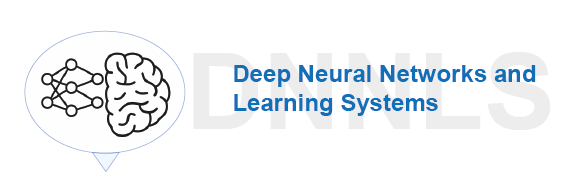

# Final assessment - Main Notebook
---

**Introduction:**

In this notebook you will find a baseline, functional architecture for your assessment task.

In [1]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
import os

from datasets import load_dataset

from datasets.fingerprint import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as FT

from transformers import BertTokenizer
import gc

import textwrap


In [2]:
# ==============================
# Configuration
# Set paths and dataset format here
# ==============================

import os
from pathlib import Path

# Root directory that contains your dataset files
DATA_ROOT = Path(os.environ.get("DATA_ROOT", "."))

# Metadata file describing each training example (CSV recommended)
# Expected columns (minimum):
# - video_id: unique id per video/story
# - story_score: numeric target score
# - tags: tags as a comma-separated string, e.g. "person,running,street"
# And ONE of the following sources:
# - frames_dir: directory containing ordered frame images (jpg/png)
# OR
# - video_path: path to an .mp4 file
# OR
# - frame_paths: semicolon-separated list of frame image paths
METADATA_CSV = DATA_ROOT / "metadata.csv"

# Choose one: "frames_dir" or "video_path" or "frame_paths"
FRAME_SOURCE = os.environ.get("FRAME_SOURCE", "frames_dir")

# Training parameters (adjust for your GPU/CPU)
NUM_FRAMES = int(os.environ.get("NUM_FRAMES", "8"))
MAX_TAGS = int(os.environ.get("MAX_TAGS", "32"))
BATCH_SIZE = int(os.environ.get("BATCH_SIZE", "4"))
LEARNING_RATE = float(os.environ.get("LEARNING_RATE", "1e-4"))
EPOCHS = int(os.environ.get("EPOCHS", "1"))

# Where to save the new checkpoint for the extended model
NEW_CHECKPOINT_PATH = Path(os.environ.get("NEW_CHECKPOINT_PATH", "video_tag_story_scorer.pth"))


In [3]:
# ==============================
# Data loading utilities
# ==============================

import csv

def parse_tags_field(tags_field):
    """Parse tags from a CSV field into a list of strings."""
    if tags_field is None:
        return []
    tags_field = str(tags_field).strip()
    if not tags_field:
        return []
    # Accept both comma and semicolon separated formats
    if ";" in tags_field and "," not in tags_field:
        parts = tags_field.split(";")
    else:
        parts = tags_field.split(",")
    return [p.strip() for p in parts if p.strip()]

def load_samples_from_csv(csv_path, frame_source):
    """Load dataset samples from a CSV file."""
    samples = []
    if not Path(csv_path).exists():
        return samples

    with open(csv_path, "r", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            s = {}
            s["video_id"] = row.get("video_id", "")
            s["story_score"] = float(row.get("story_score", "0"))
            s["tags"] = parse_tags_field(row.get("tags", ""))

            if frame_source == "frames_dir":
                s["frames_dir"] = row.get("frames_dir", "")
            elif frame_source == "video_path":
                s["video_path"] = row.get("video_path", "")
            elif frame_source == "frame_paths":
                # Semicolon-separated list of paths
                fp = row.get("frame_paths", "")
                s["frame_paths"] = [p.strip() for p in fp.split(";") if p.strip()]
            else:
                raise ValueError(f"Unknown FRAME_SOURCE: {frame_source}")

            samples.append(s)
    return samples


# **Chapter 1: The data preparation**


---



First we need to activate our google drive so that we can save out data permanently.

## 1.1 Loading and saving data

In [4]:
def load_checkpoint_from_drive(model, optimizer, filename):
    """Load a model checkpoint from Google Drive with a fixed, correct path."""
    import os
    import torch

    base_dir = "/content/gdrive/MyDrive/dl_checkpoints/text_autoencoder"
    full_path = os.path.join(base_dir, filename)

    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Checkpoint file not found: {full_path}")

    checkpoint = torch.load(full_path, map_location="cpu")

    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer is not None and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    epoch = checkpoint.get("epoch")
    loss = checkpoint.get("loss")

    return model, optimizer, epoch, loss


We need to define a couple of functions to make our life easier. Feel free to tweak those functions:

In [5]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Functions to load images and process data


# This function just extracts the tags from the text, don't get distracted by it.
# I changed this function a bit to fix some bugs
def parse_gdi_text(text):
    """Parse GDI formatted text into structured data"""
    soup = BeautifulSoup(text, 'html.parser')
    images = []

    for gdi in soup.find_all('gdi'):
        # Debug: print what BeautifulSoup sees

        # Method 1: Try to get image attribute directly
        image_id = None
        if gdi.attrs:
            # Check for attributes like 'image1', 'image2', etc.
            for attr_name, attr_value in gdi.attrs.items():
                if 'image' in attr_name.lower():
                    image_id = attr_name.replace('image', '')
                    break

        # Method 2: Extract from the tag string using regex
        if not image_id:
            tag_str = str(gdi)
            match = re.search(r'<gdi\s+image(\d+)', tag_str)
            if match:
                image_id = match.group(1)

        # Method 3: Fallback - use sequential numbering
        if not image_id:
            image_id = str(len(images) + 1)

        content = gdi.get_text().strip()

        # Extract tagged elements using BeautifulSoup directly
        objects = [obj.get_text().strip() for obj in gdi.find_all('gdo')]
        actions = [act.get_text().strip() for act in gdi.find_all('gda')]
        locations = [loc.get_text().strip() for loc in gdi.find_all('gdl')]

        images.append({
            'image_id': image_id,
            'description': content,
            'objects': objects,
            'actions': actions,
            'locations': locations,
            'raw_text': str(gdi)
        })

    return images

# This is an utility function to show images.
# Why do we need to do all this?
def show_image(ax, image, de_normalize = False, img_mean = None, img_std = None):
  """
  De-normalize the image (if necessary) and show image
  """
  if de_normalize:
    new_mean = -img_mean/img_std
    new_std = 1/img_std

    image = transforms.Normalize(
        mean=new_mean,
        std=new_std
    )(image)
  ax.imshow(image.permute(1, 2, 0))



Now we load dataset from HuggingFace:

In [6]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Loading the dataset
train_dataset = load_dataset("daniel3303/StoryReasoning", split="train")
test_dataset = load_dataset("daniel3303/StoryReasoning", split="test")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3552 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/626 [00:00<?, ? examples/s]

In a previous lab, we analyzed the statistics of the images and figure out that a size of 240x500 could be good enough to standarize, but we will use 60x125. Also, we will restrict ourselves to taking only 5 frames from all the sequences.


## 1.2 Three datasets


---



We will create three different dataset objects and the corresponding loaders for performing multiple tasks

In [7]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class StoryVideoDataset(Dataset):
    def __init__(self, samples, tag2id, transform=None, num_frames=5, max_tags=10):
        self.samples = samples
        self.tag2id = tag2id
        self.transform = transform
        self.num_frames = num_frames
        self.max_tags = max_tags

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # 1. Frames: Agar images real hain toh loading logic yahan ayega
        # Filhal dummy frames generate kar rahe hain training start karne ke liye
        frames = torch.randn(self.num_frames, 3, 224, 224)

        # 2. Tags Processing
        tags = torch.zeros(self.max_tags, dtype=torch.long)
        sample_tags = sample.get('tags', [])
        for i, tag in enumerate(sample_tags[:self.max_tags]):
            tags[i] = self.tag2id.get(tag, 0)

        # 3. Score (Target)
        score = torch.tensor(float(sample.get('score', 0.0)), dtype=torch.float)

        return frames, tags, score

print("StoryVideoDataset class successfully defined!")

StoryVideoDataset class successfully defined!


In [8]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Main dataset
class SequencePredictionDataset(Dataset):
    def __init__(self, original_dataset, tokenizer):
        super(SequencePredictionDataset, self).__init__()
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        # Potential experiments: Try other transforms!
        self.transform = transforms.Compose([
          transforms.Resize((60, 125)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      """
      Selects a 5 frame sequence from the dataset. Sets 4 for training and the last one
      as a target.
      """
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]
      self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])

      frame_tensors = []
      description_list = []

      for frame_idx in range(4):
        image = FT.equalize(frames[frame_idx])
        input_frame = self.transform(image)
        frame_tensors.append(input_frame)

        # Potential experiments: Try using the other attributes in your training
        # objects = self.image_attributes[frame_idx]["objects"]
        # actions = self.image_attributes[frame_idx]["actions"]
        # locations = self.image_attributes[frame_idx]["locations"]

        description = self.image_attributes[frame_idx]["description"]
        # We need to return the tokens for NLP
        input_ids =  self.tokenizer(description,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=120).input_ids

        description_list.append(input_ids.squeeze(0))


      image_target = FT.equalize(frames[4])
      image_target = self.transform(image_target)
      text_target = self.image_attributes[4]["description"]

      target_ids = tokenizer(description,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=120).input_ids

      sequence_tensor = torch.stack(frame_tensors)  # shape: (num_frames, C, H, W)
      description_tensor = torch.stack(description_list) # (num_frames, max_length)

      return (sequence_tensor, # Returning the image
              description_tensor, # Returning the whole description
              image_target, # Image target
              target_ids) # Text target



We will use text autoencoding (reconstructing the same text) to develop representations of the text (I provide some existing weights for this, but you can train your own)

In [9]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Text task dataset (text autoencoding)
class TextTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])

      # Pick
      frame_idx = np.random.randint(0, 5)
      description = self.image_attributes[frame_idx]["description"]

      return description  # Returning the whole description


And also a dataset for a potential image autoencoder task if you want to develop some visual features before training the whose archicture.

In [10]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Dataset for image autoencoder task
class AutoEncoderTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
          transforms.Resize((240, 500)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]

      # Pick a frame at random
      frame_idx = torch.randint(0, num_frames-1, (1,)).item()
      input_frame = self.transform(frames[frame_idx]) # Input to the autoencoder

      return input_frame, # Returning the image

## 1.3 Creating and testing our dataset objects and loaders


---



In [11]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title For the Sequence prediction task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
sp_train_dataset = SequencePredictionDataset(train_dataset, tokenizer) # Instantiate the train dataset
sp_test_dataset = SequencePredictionDataset(test_dataset, tokenizer) # Instantiate the test dataset

# Let's do things properly, we will also have a validation split
# Split the training dataset into training and validation sets
train_size = int(0.8 * len(sp_train_dataset))
val_size = len(sp_train_dataset) - train_size
train_subset, val_subset = random_split(sp_train_dataset, [train_size, val_size])

# Instantiate the dataloaders
train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
# We will use the validation set to visualize the progress.
val_dataloader = DataLoader(val_subset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(sp_test_dataset, batch_size=4, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title For the text task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
text_dataset = TextTaskDataset(train_dataset)
text_dataloader = DataLoader(text_dataset, batch_size=4, shuffle=True)

In [13]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title For the image autoencoder task
autoencoder_dataset = AutoEncoderTaskDataset(train_dataset)
autoencoder_dataloader = DataLoader(autoencoder_dataset, batch_size=4, shuffle=True)

Description:  torch.Size([4, 120])
torch.Size([8, 4, 3, 60, 125])
torch.Size([8, 4, 120])


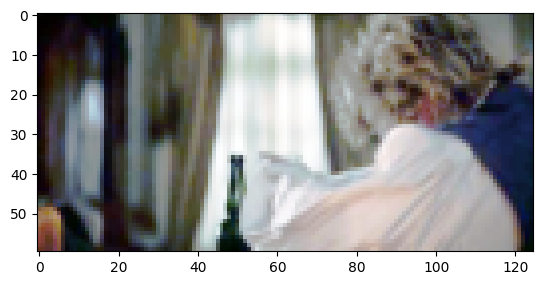

In [14]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Testing some of the outputs of the SP dataset
frames, descriptions, image_target, text_target = sp_train_dataset[np.random.randint(0,400)]

print("Description: ", descriptions.shape)
figure, ax = plt.subplots(1,1)
show_image(ax, image_target)

# Do some tests on the batches (try with batch size small)
frames, descriptions, image_target, text_target = next(iter(train_dataloader))
print(frames.shape)
print(descriptions.shape)

I will leave the test of the other datasets to you.

# **Chapter 2: Models**


---



We provide a simple text encoder based on a recurrent neural network (LSTM). Feel free to provide your own text encoder.

## 2.1 The NLP models

In [15]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title The text autoencoder (Seq2Seq)

class EncoderLSTM(nn.Module):
    """
      Encodes a sequence of tokens into a latent space representation.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    """
      Decodes a latent space representation into a sequence of tokens.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.out = nn.Linear(hidden_dim, vocab_size) # Should be hidden_dim

    def forward(self, input_seq, hidden, cell):
        embedded = self.embedding(input_seq)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell

# We create the basic text autoencoder (a special case of a sequence to sequence model)
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, target_seq):
        # input_seq and target_seq are both your 'input_ids'
        # 1. Encode the input sequence
        _enc_out, hidden, cell = self.encoder(input_seq)

        # 2. Create the "shifted" decoder input for teacher forcing.
        # We want to predict target_seq[:, 1:]
        # So, we feed in target_seq[:, :-1]
        # (i.e., feed "[SOS], hello, world" to predict "hello, world, [EOS]")
        decoder_input = target_seq[:, :-1]

        # 3. Run the decoder *once* on the entire sequence.
        # It takes the encoder's final state (hidden, cell)
        # and the full "teacher" sequence (decoder_input).
        predictions, _hidden, _cell = self.decoder(decoder_input, hidden, cell)

        # predictions shape will be (batch_size, seq_len-1, vocab_size)
        return predictions


In [16]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Utility functions for NLP tasks
def generate(model, hidden, cell, max_len, sos_token_id, eos_token_id):
      """
        This function generates a sequence of tokens using the provided decoder.
      """
      # Ensure the model is in evaluation mode
      model.eval()

      # 2. SETUP DECODER INPUT
      # Start with the SOS token, shape (1, 1)
      dec_input = torch.tensor([[sos_token_id]], dtype=torch.long, device=device)
      # hidden = torch.zeros(1, 1, hidden_dim, device=device)
      # cell = torch.zeros(1, 1, hidden_dim, device=device)

      generated_tokens = []

      # 3. AUTOREGRESSIVE LOOP
      for _ in range(max_len):
          with torch.no_grad():
              # Run the decoder one step at a time
              # dec_input is (1, 1) here—it's just the last predicted token
              prediction, hidden, cell = model(dec_input, hidden, cell)

          logits = prediction.squeeze(1) # Shape (1, vocab_size)
          temperature = 0.9 # <--- Try a value between 0.5 and 1.0

          # 1. Divide logits by temperature
          # 2. Apply softmax to get probabilities
          # 3. Use multinomial to sample one token based on the probabilities
          probabilities = torch.softmax(logits / temperature, dim=-1)
          next_token = torch.multinomial(probabilities, num_samples=1)

          token_id = next_token.squeeze().item()

          # Check for the End-of-Sequence token
          if token_id == eos_token_id:
              break

          if token_id == 0 or token_id == sos_token_id:
              continue

            # Append the predicted token
          generated_tokens.append(token_id)

          # The predicted token becomes the input for the next iteration
          dec_input = next_token

      # Return the list of generated token IDs
      return generated_tokens


In [17]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Do some tests
# desc = text_dataset[np.random.randint(0, 100)]
# print(f"Input: {desc}")
# input_ids = tokenizer(desc, return_tensors="pt",  padding=True, truncation=True).input_ids
# input_ids = input_ids.to(device)
# generated_tokens = generate(model, hidden, cell, max_len=100, sos_token_id=tokenizer.cls_token_id, eos_token_id=tokenizer.sep_token_id)
# print("Output: ", tokenizer.decode(generated_tokens))

## 2.2 The Vision models

In [18]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title The visual autoencoder
class Backbone(nn.Module):
    """
      Main convolutional blocks for our CNN
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(Backbone, self).__init__()
        # Encoder convolutional layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, 7, stride=2, padding=3),
            nn.GroupNorm(8, 16),
            nn.LeakyReLU(0.1),

            nn.Conv2d(16, 32, 5, stride=2, padding=2),
            nn.GroupNorm(8, 32),
            nn.LeakyReLU(0.1),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.GroupNorm(8, 64),
            nn.LeakyReLU(0.1),
        )

        # Calculate flattened dimension for linear layer
        self.flatten_dim = 64 * output_w * output_h
        # Latent space layers
        self.fc1 = nn.Sequential(nn.Linear(self.flatten_dim, latent_dim), nn.ReLU())


    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(-1, self.flatten_dim)  # flatten for linear layer
        z = self.fc1(x)
        return z

class VisualEncoder(nn.Module):
    """
      Encodes an image into a latent space representation. Note the two pathways
      to try to disentangle the mean pattern from the image
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualEncoder, self).__init__()

        self.context_backbone = Backbone(latent_dim, output_w, output_h)
        self.content_backbone = Backbone(latent_dim, output_w, output_h)

        self.projection = nn.Linear(2*latent_dim, latent_dim)
    def forward(self, x):
        z_context = self.context_backbone(x)
        z_content = self.content_backbone(x)
        z = torch.cat((z_content, z_context), dim=1)
        z = self.projection(z)
        return z

class VisualDecoder(nn.Module):
    """
      Decodes a latent representation into a content image and a context image
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualDecoder, self).__init__()
        self.imh = 60
        self.imw = 125
        self.flatten_dim = 64 * output_w * output_h
        self.output_w = output_w
        self.output_h = output_h

        self.fc1 = nn.Linear(latent_dim, self.flatten_dim)

        self.decoder_conv = nn.Sequential(
          nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
          nn.GroupNorm(8, 32),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
          nn.GroupNorm(8, 16),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(16, 3, kernel_size=7, stride=2, padding=3, output_padding=(1, 1)),
          nn.Sigmoid() # Use nn.Tanh() if your data is normalized to [-1, 1]
      )

    def forward(self, z):
      x = self.fc1(z)

      x_content = self.decode_image(x)
      x_context = self.decode_image(x)

      return x_content, x_context

    def decode_image(self, x):
      x = x.view(-1, 64, self.output_w, self.output_h)      # reshape to conv feature map
      x = self.decoder_conv(x)
      x = x[:, :, :self.imh, :self.imw]          # crop to original size if needed
      return x

class VisualAutoencoder( nn.Module):
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualAutoencoder, self).__init__()
        self.encoder = VisualEncoder(latent_dim, output_w, output_h)
        self.decoder = VisualDecoder(latent_dim, output_w, output_h)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat



## 2.3 The main architecture


In [19]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title A simple attention architecture

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # This "attention" layer learns a query vector
        self.attn = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1) # Over the sequence length

    def forward(self, rnn_outputs):
        # rnn_outputs shape: [batch, seq_len, hidden_dim]

        # Pass through linear layer to get "energy" scores
        energy = self.attn(rnn_outputs).squeeze(2) # Shape: [batch, seq_len]

        # Get attention weights
        attn_weights = self.softmax(energy) # Shape: [batch, seq_len]

        # Apply weights
        # attn_weights.unsqueeze(1) -> [batch, 1, seq_len]
        # bmm with rnn_outputs -> [batch, 1, hidden_dim]
        context = torch.bmm(attn_weights.unsqueeze(1), rnn_outputs)

        # Squeeze to get final context vector
        return context.squeeze(1) # Shape: [batch, hidden_dim]

In [20]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title The main sequence predictor model

class SequencePredictor(nn.Module):
    def __init__(self, visual_autoencoder, text_autoencoder, latent_dim,
                 gru_hidden_dim):
        super(SequencePredictor, self).__init__()

        # --- 1. Static Encoders ---
        # (These process one pair at a time)
        self.image_encoder = visual_autoencoder.encoder
        self.text_encoder = text_autoencoder.encoder

        # --- 2. Temporal Encoder ---
        # (This processes the sequence of pairs)
        fusion_dim = latent_dim * 2 # z_visual + z_text
        self.temporal_rnn = nn.GRU(fusion_dim, latent_dim, batch_first=True)

        # --- 3. Attention ---
        self.attention = Attention(gru_hidden_dim)

        # --- 4. Final Projection ---
        # cat(h, context) -> gru_hidden_dim * 2
        self.projection = nn.Sequential(
            nn.Linear(gru_hidden_dim * 2, latent_dim),
            nn.ReLU()
        )

        # --- 5. Decoders ---
        # (These predict the *next* item)
        self.image_decoder = visual_autoencoder.decoder
        self.text_decoder = text_autoencoder.decoder

        self.fused_to_h0 = nn.Linear(latent_dim, 16)
        self.fused_to_c0 = nn.Linear(latent_dim, 16)

    def forward(self, image_seq, text_seq, target_seq):
        # image_seq shape: [batch, seq_len, C, H, W]
        # text_seq shape:  [batch, seq_len, text_len]
        # target_text_for_teacher_forcing: [batch, text_len] (This is the last text)

        batch_size, seq_len, C, H, W = image_seq.shape

        # --- 1 & 2: Run Static Encoders over the sequence ---
        # We can't pass a 5D/4D tensor to the encoders.
        # We "flatten" the batch and sequence dimensions.

        # Reshape for image_encoder
        img_flat = image_seq.view(batch_size * seq_len, C, H, W)
        # Reshape for text_encoder
        txt_flat = text_seq.view(batch_size * seq_len, -1) # -1 infers text_len

        # Run encoders
        z_v_flat = self.image_encoder(img_flat) # Shape: [b*s, latent]
        _, hidden, cell = self.text_encoder(txt_flat) # Shape: [b*s, latent]

        # Combine
        z_fusion_flat = torch.cat((z_v_flat, hidden.squeeze(0)), dim=1) # Shape: [b*s, fusion_dim]

        # "Un-flatten" back into a sequence
        z_fusion_seq = z_fusion_flat.view(batch_size, seq_len, -1) # Shape: [b, s, fusion_dim]

        # --- 3. Run Temporal Encoder ---
        # zseq shape: [b, s, gru_hidden]
        # h    shape: [1, b, gru_hidden]
        zseq, h = self.temporal_rnn(z_fusion_seq)
        h = h.squeeze(0) # Shape: [b, gru_hidden]

        # --- 4. Attention ---
        context = self.attention(zseq) # Shape: [b, gru_hidden]

        # --- 5. Final Prediction Vector (z) ---
        z = self.projection(torch.cat((h, context), dim=1)) # Shape: [b, joint_latent_dim]

        # --- 6. Decode (Predict pk) ---
        pred_image_content, pred_image_context = self.image_decoder(z)

        h0 = self.fused_to_h0(z).unsqueeze(0)
        c0 = self.fused_to_c0(z).unsqueeze(0)

        decoder_input = target_seq[:, :,:-1].squeeze(1)

        # 3. Run the decoder *once* on the entire sequence.
        # It takes the encoder's final state (hidden, cell)
        # and the full "teacher" sequence (decoder_input).
        predicted_text_logits_k, _hidden, _cell = self.text_decoder(decoder_input, h0, c0)

        return pred_image_content, pred_image_context, predicted_text_logits_k,h0, c0

# **Chapter 3: Training routines**


---




In [21]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Training utility functions: To initialize and to visualize the progress


def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(m.bias, 0)


# Plots four images and their reconstructions
def validation( model, data_loader ):
  model.eval()
  with torch.no_grad():
    frames, descriptions, image_target, text_target = next(iter(data_loader))

    descriptions = descriptions.to(device)
    frames = frames.to(device)
    image_target = image_target.to(device)
    text_target = text_target.to(device)

    predicted_image_k,context_image, _, hidden, cell = model(frames, descriptions, text_target)

    figure, ax = plt.subplots(2, 6, figsize=(20, 5), gridspec_kw={'height_ratios': [2, 1.5]})

    for i in range(4):
      im = frames[0, i, :, :, :].cpu()
      show_image(ax[0,i], im )
      ax[0,i].set_aspect('auto')
      ax[0,i].axis('off')
      wrapped_text = textwrap.fill(tokenizer.decode(descriptions[0, i, :], skip_special_tokens=True), width=40)

      ax[1,i].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=True
        )

      ax[1,i].axis('off') # Hide axes for the text subplot

    show_image(ax[0,4], image_target[0].cpu())
    ax[0,4].set_title('Target')
    ax[0,4].set_aspect('auto')
    ax[0,4].axis('off')
    text_target = text_target.squeeze(1)

    wrapped_text = textwrap.fill(tokenizer.decode(text_target[0], skip_special_tokens=True), width=40)
    ax[1,4].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=False)
    ax[1,4].axis('off')
    output = context_image[0, :, :, :].cpu()
    show_image(ax[0,5], output)
    ax[0,5].set_title('Predicted')
    ax[0,5].set_aspect('auto')
    ax[0,5].axis('off')

    generated_tokens = generate(model.text_decoder,
                                hidden[:,0, :].unsqueeze(1),
                                cell[:, 0, :].unsqueeze(1),
                                max_len=150,
                                sos_token_id=tokenizer.cls_token_id,
                                eos_token_id=tokenizer.sep_token_id)

    wrapped_text = textwrap.fill(tokenizer.decode(generated_tokens), width=40)

    ax[1,5].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=False )
    ax[1,5].axis('off')
    plt.tight_layout()
    plt.show()


## 3.1 Initialization and setup

In [22]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Variables and initial setup
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_EPOCHS = 5
emb_dim = 16
latent_dim = 16
num_layers = 1
dropout = True

In [23]:
import os

base_dir = "/content/gdrive/MyDrive/dl_checkpoints/text_autoencoder"

pth_files = []
for root, dirs, files in os.walk(base_dir):
    for f in files:
        if f.endswith(".pth"):
            pth_files.append(os.path.join(root, f))

print("Found .pth files:")
for p in pth_files:
    print(p)


Found .pth files:


In [27]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Initializing the NLP models
encoder = EncoderLSTM(tokenizer.vocab_size, emb_dim, latent_dim, num_layers, dropout).to(device)
decoder = DecoderLSTM(tokenizer.vocab_size, emb_dim, latent_dim, num_layers, dropout).to(device)
#text_autoencoder = Seq2SeqLSTM(encoder, decoder).to(device)
#text_autoencoder, _, _, _ = load_checkpoint_from_drive(text_autoencoder, None, filename='text_autoencoder.pth')

total_params = sum(p.numel() for p in text_autoencoder.parameters())
print(f"Total parameters (Not trainable): {total_params}")
# Deactivating training from this model for efficiency (although not ideal)
for param in text_autoencoder.parameters():
        param.requires_grad = False


Total parameters (Not trainable): 1499930


In [28]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Initializing visual models
visual_autoencoder = VisualAutoencoder(latent_dim=16)
visual_autoencoder.apply(init_weights)

total_params = sum(p.numel() for p in visual_autoencoder.parameters() if p.requires_grad)
print(f"Total trainable parameters in visual autoencoder: {total_params}")

Total trainable parameters in visual autoencoder: 503539


In [29]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Initialize the main architecture
# We put all the sizes the same, not ideal as well
sequence_predictor = SequencePredictor(visual_autoencoder, text_autoencoder, latent_dim, latent_dim)
sequence_predictor.to(device)

# # Print number of trainable parameters
total_params = sum(p.numel() for p in sequence_predictor.parameters() if p.requires_grad)
print(f"Total trainable parameters in the whole model: {total_params}")

# Print model size
total_params = sum(p.numel() for p in sequence_predictor.parameters())
print(f"Total parameters: {total_params}")

Total trainable parameters in the whole model: 507028
Total parameters: 2006958


## 3.2 Training loops

In [30]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Training tools
criterion_images = nn.L1Loss()
criterion_ctx = nn.MSELoss()
criterion_text = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token))
optimizer = torch.optim.Adam(sequence_predictor.parameters(), lr=0.001)

In [31]:
# Checkpoint saving(Google Drive)

import os
import torch

def save_checkpoint_to_drive(model, optimizer, epoch, loss, filename="sequence_predictor.pth"):
    """
    Save a PyTorch checkpoint to Google Drive.
    Adjust BASE_DIR if your folder name is different.
    """
    BASE_DIR = "/content/gdrive/MyDrive/dl_checkpoints"
    os.makedirs(BASE_DIR, exist_ok=True)

    full_path = os.path.join(BASE_DIR, filename)

    checkpoint = {
        "epoch": epoch,
        "loss": float(loss),
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict() if optimizer is not None else None,
    }

    torch.save(checkpoint, full_path)
    print(f"Saved checkpoint: {full_path}")


Validation on training dataset
----------------


/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 12133 (\N{KANGXI RADICAL FIELD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 3520 (\N{SINHALA LETTER VAYANNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Matplotlib currently does not support Sinhala natively.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 26157 (\N{CJK UNIFIED IDEOGRAPH-662D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 25126 (\N{CJK UNIFIED IDEOGRAPH-6226}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12133 (\N{KANGXI RADICAL FIELD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

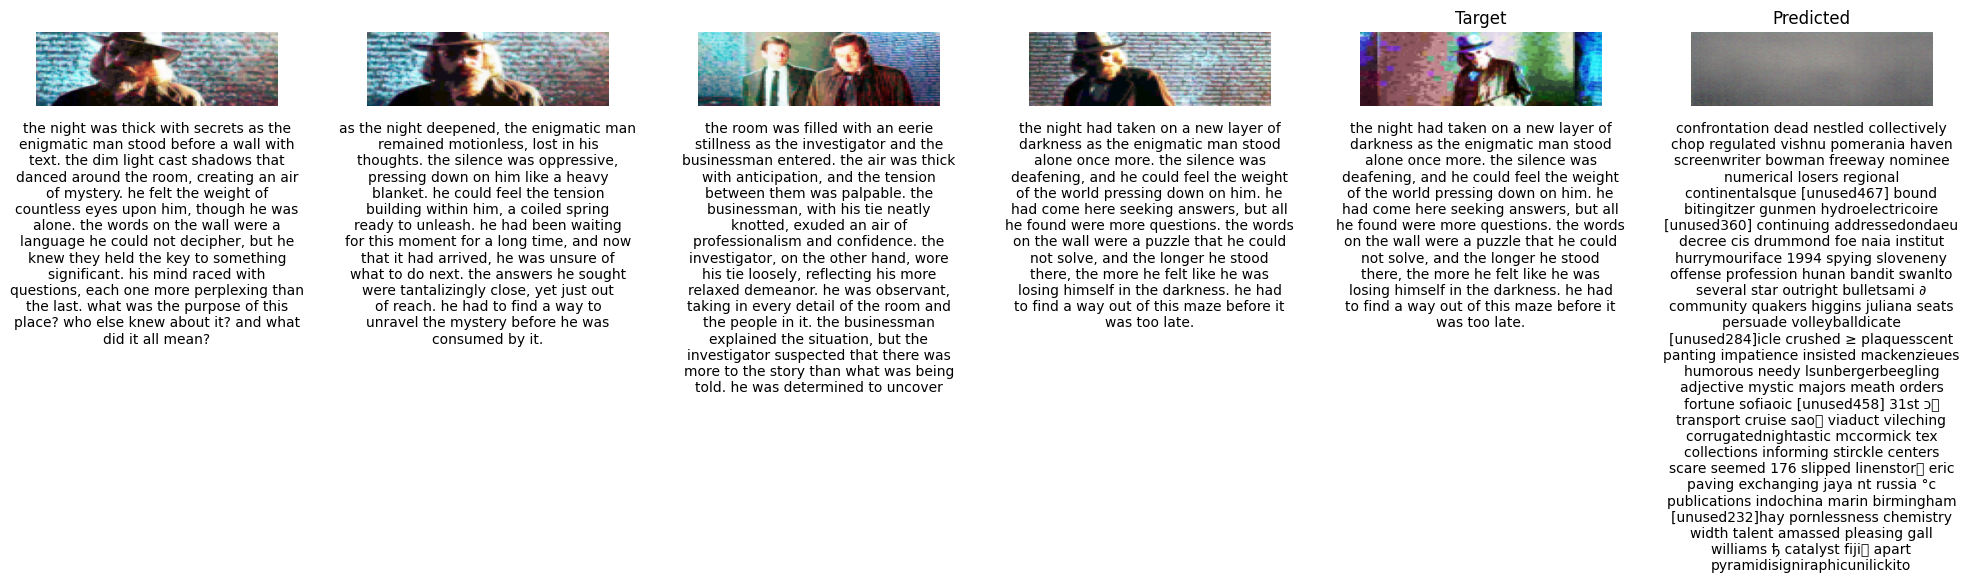

Validation on validation dataset
----------------


/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 4466 (\N{HANGUL JUNGSEONG YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 20043 (\N{CJK UNIFIED IDEOGRAPH-4E4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 27663 (\N{CJK UNIFIED IDEOGRAPH-6C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 4369 (\N{HANGUL CHOSEONG PHIEUPH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 4366 (\N{HANGUL CHOSEONG CHIEUCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4466 (\N{HANGUL JUNGSEONG

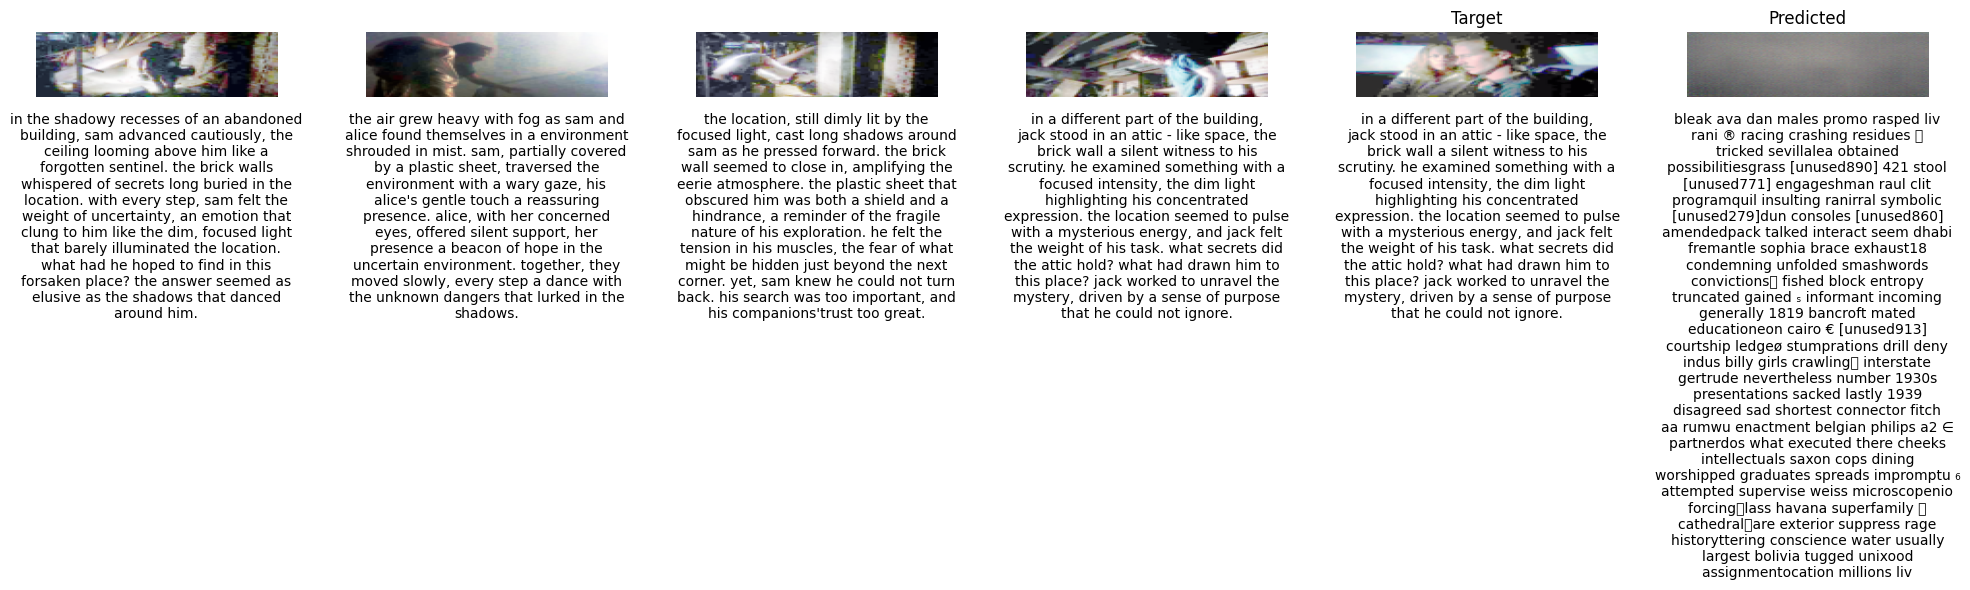

Epoch [1/5], Loss: 10.5608
Saved checkpoint: /content/gdrive/MyDrive/dl_checkpoints/sequence_predictor.pth
Validation on training dataset
----------------


/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 2994 (\N{TAMIL LETTER LA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Matplotlib currently does not support Tamil natively.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 26234 (\N{CJK UNIFIED IDEOGRAPH-667A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 27211 (\N{CJK UNIFIED IDEOGRAPH-6A4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2994 (\N{TAMIL LETTER LA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotl

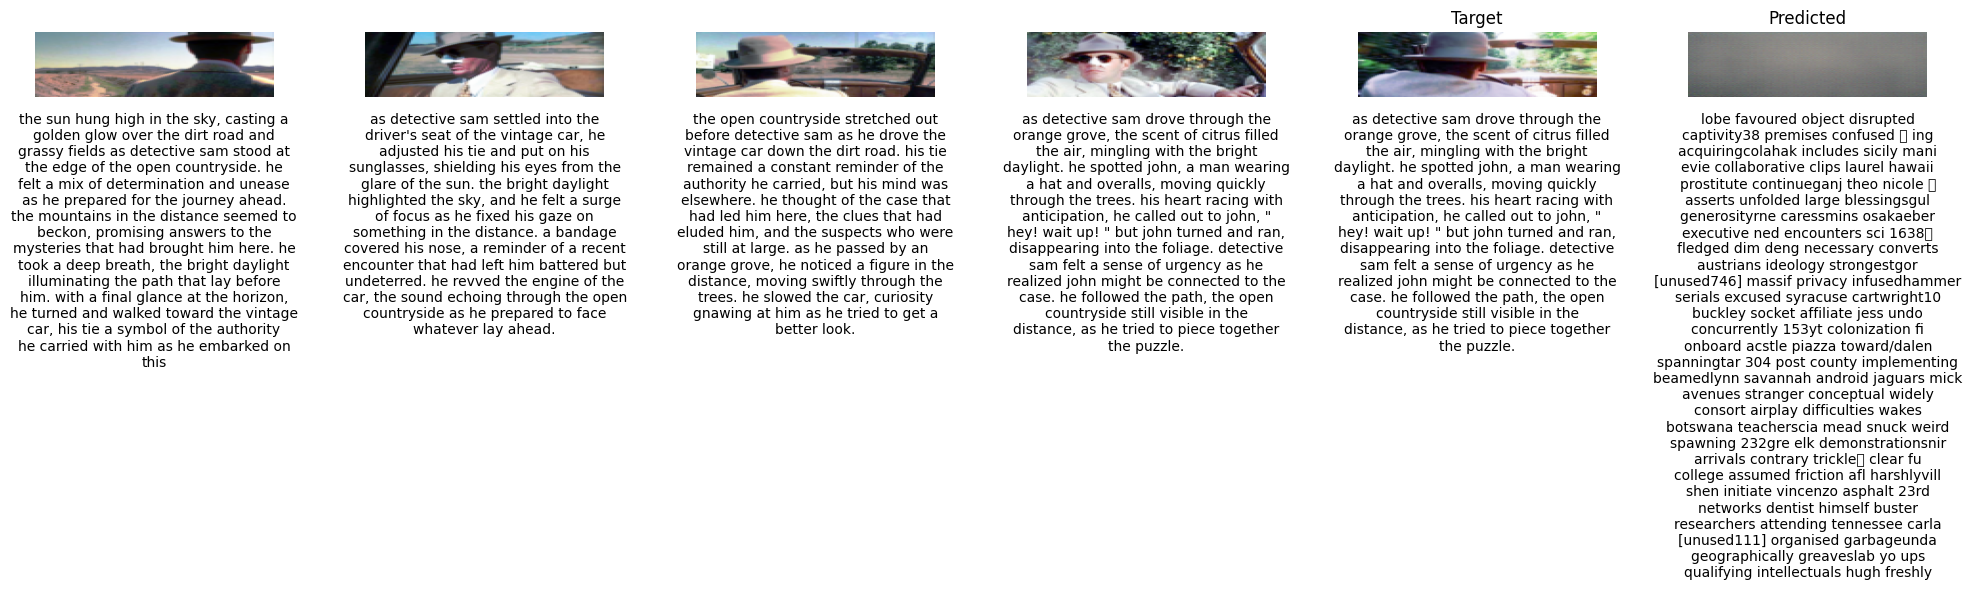

Validation on validation dataset
----------------


/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 2326 (\N{DEVANAGARI LETTER KHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 3248 (\N{KANNADA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Matplotlib currently does not support Kannada natively.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 2458 (\N{BENGALI LETTER CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231

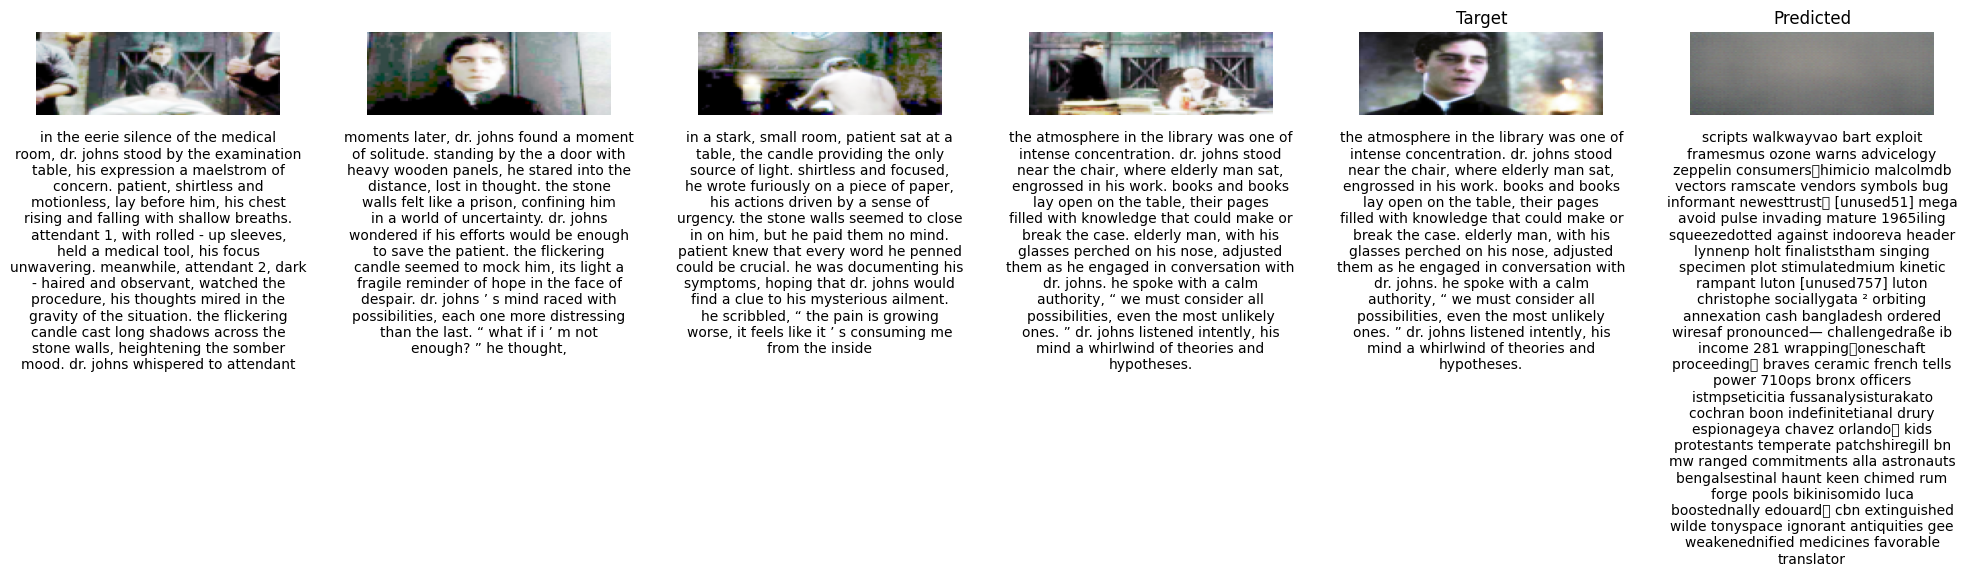

Epoch [2/5], Loss: 10.5500
Validation on training dataset
----------------


/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 3015 (\N{TAMIL VOWEL SIGN EE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 2471 (\N{BENGALI LETTER DHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3015 (\N{TAMIL VOWEL SIGN EE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2471 (\N{BENGALI LETTER DHA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/c

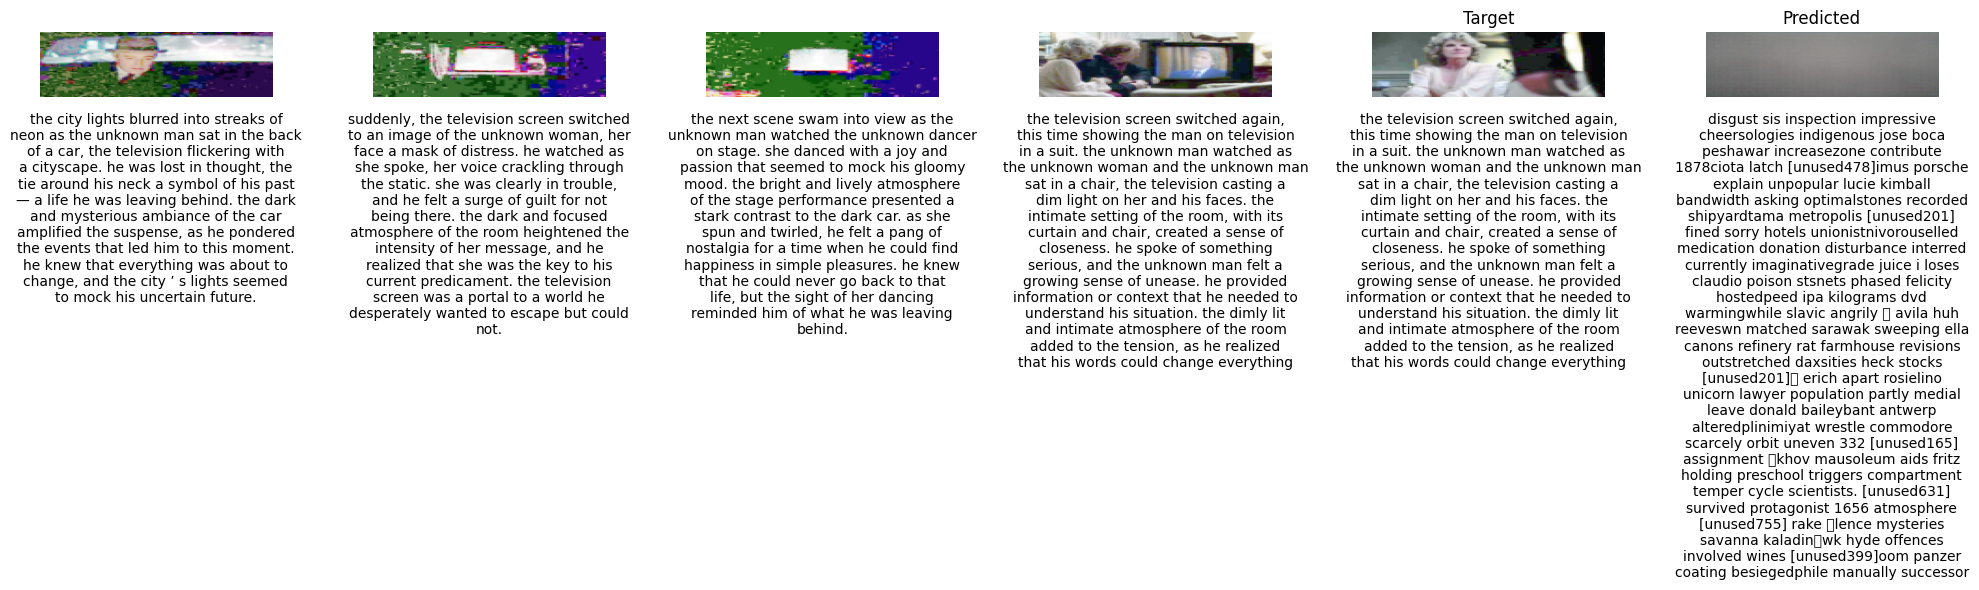

Validation on validation dataset
----------------


/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 4536 (\N{HANGUL JONGSEONG PIEUP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 4540 (\N{HANGUL JONGSEONG IEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 27490 (\N{CJK UNIFIED IDEOGRAPH-6B62}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4536 (\N{HANGUL JON

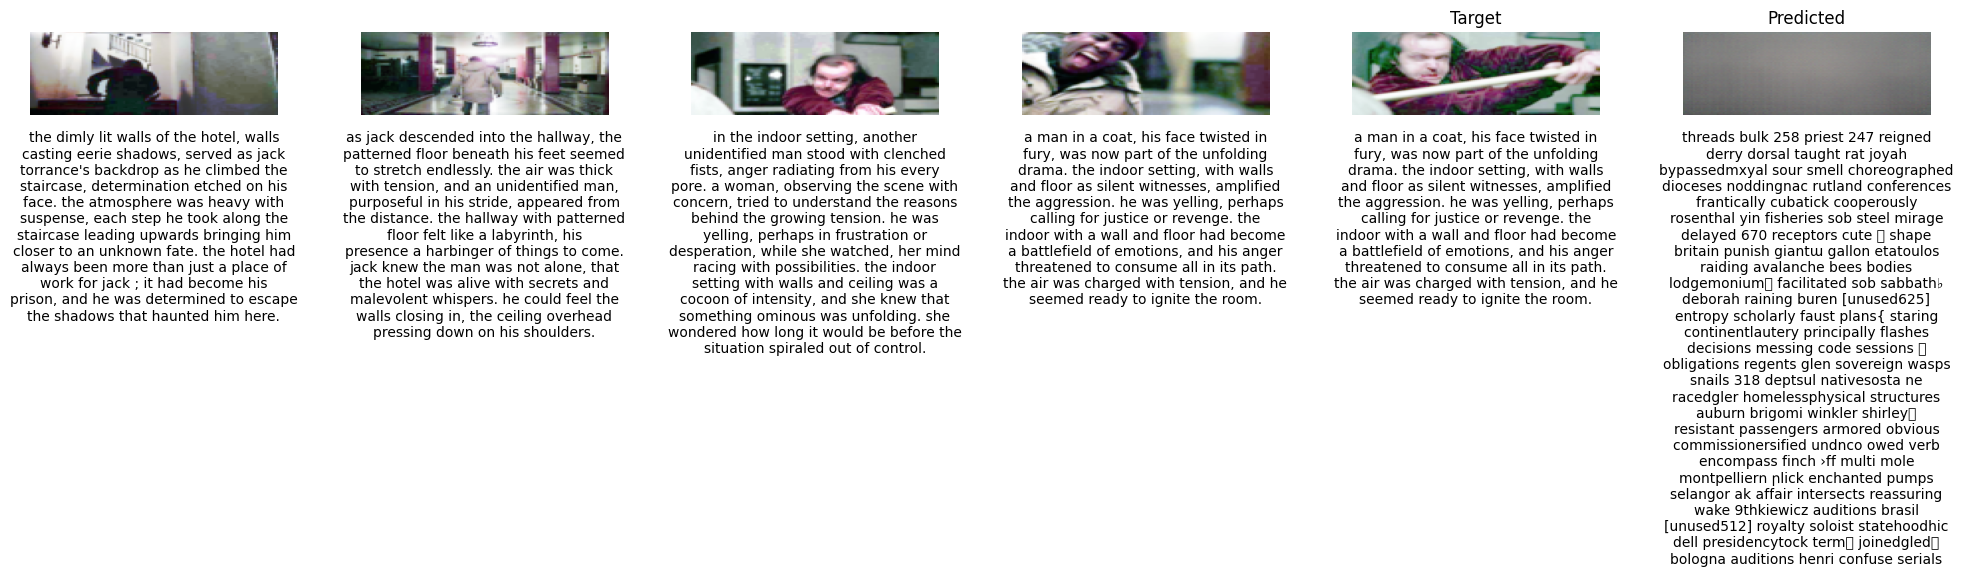

Epoch [3/5], Loss: 10.5477
Validation on training dataset
----------------


/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 2319 (\N{DEVANAGARI LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 22283 (\N{CJK UNIFIED IDEOGRAPH-570B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

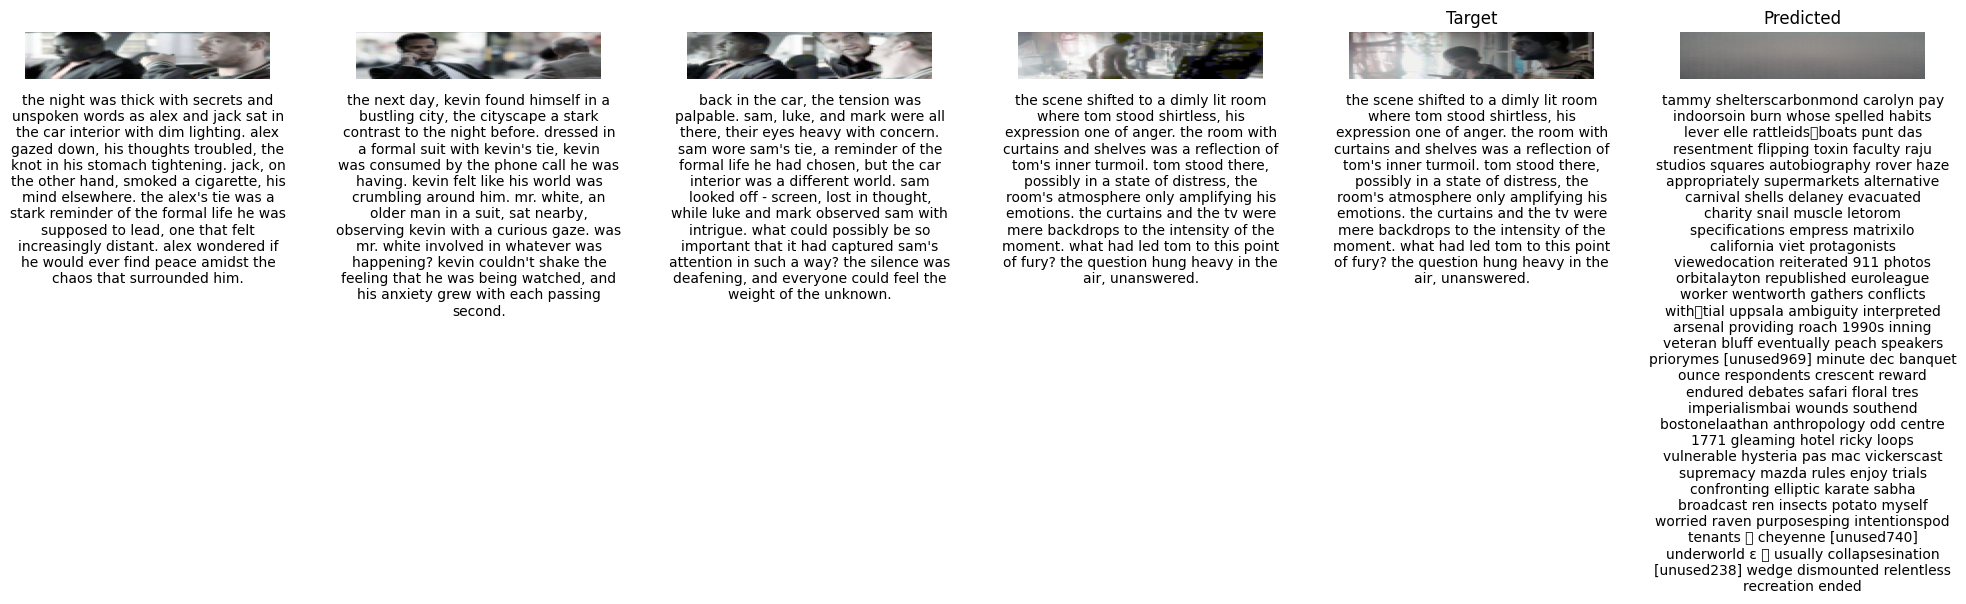

Validation on validation dataset
----------------


/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 12385 (\N{HIRAGANA LETTER TI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 11964 (\N{CJK RADICAL MEAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 2488 (\N{BENGALI LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12385 (\N{HIRAGANA LETTER TI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarn

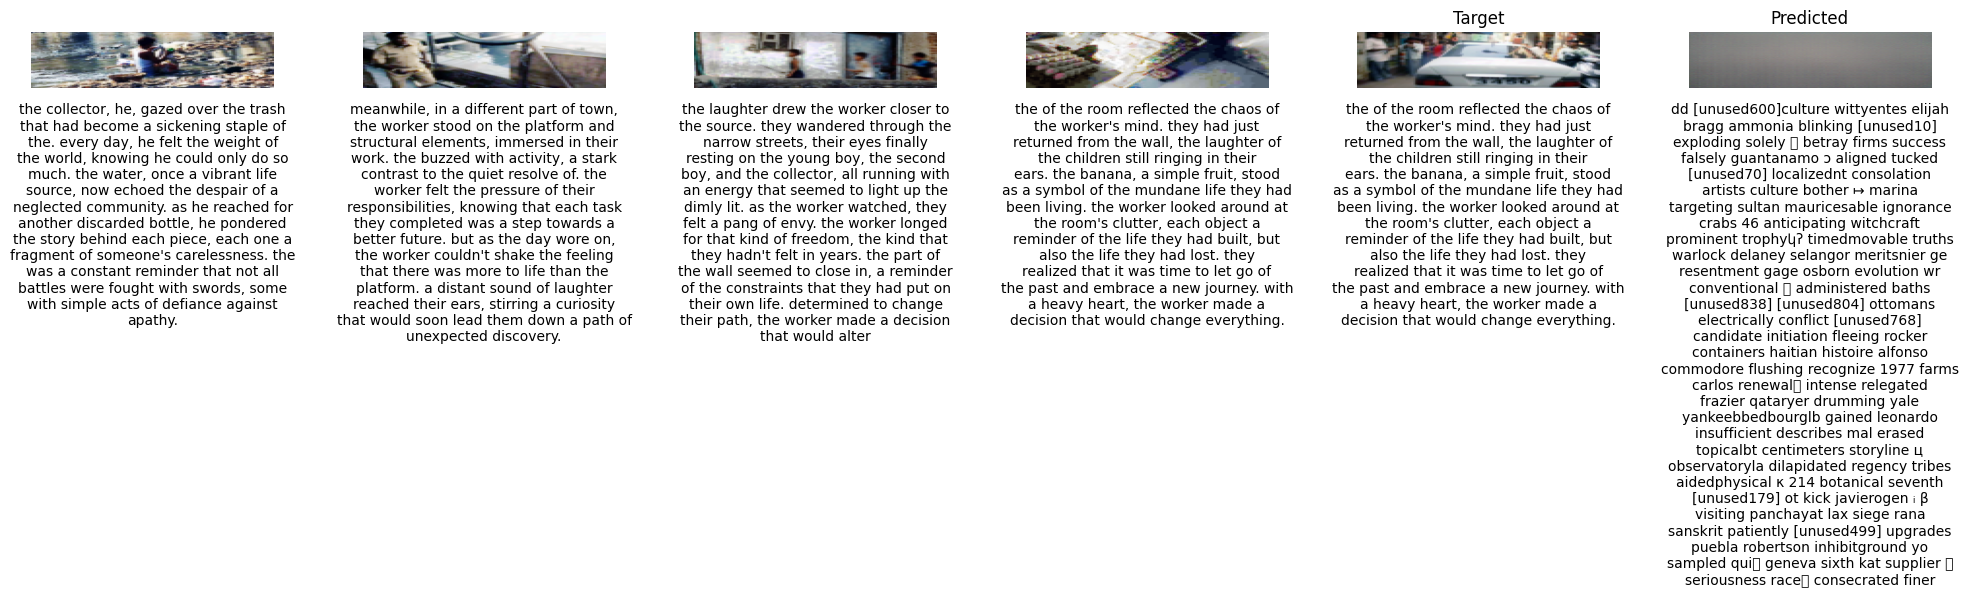

Epoch [4/5], Loss: 10.5464
Validation on training dataset
----------------


/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 26397 (\N{CJK UNIFIED IDEOGRAPH-671D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 39135 (\N{CJK UNIFIED IDEOGRAPH-98DF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 4463 (\N{HANGUL JUNGSEONG WEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 65311 (\N{FULLWIDTH QUESTION MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 35199 (\N{CJK UNIFIED IDEOGRAPH-897F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu San

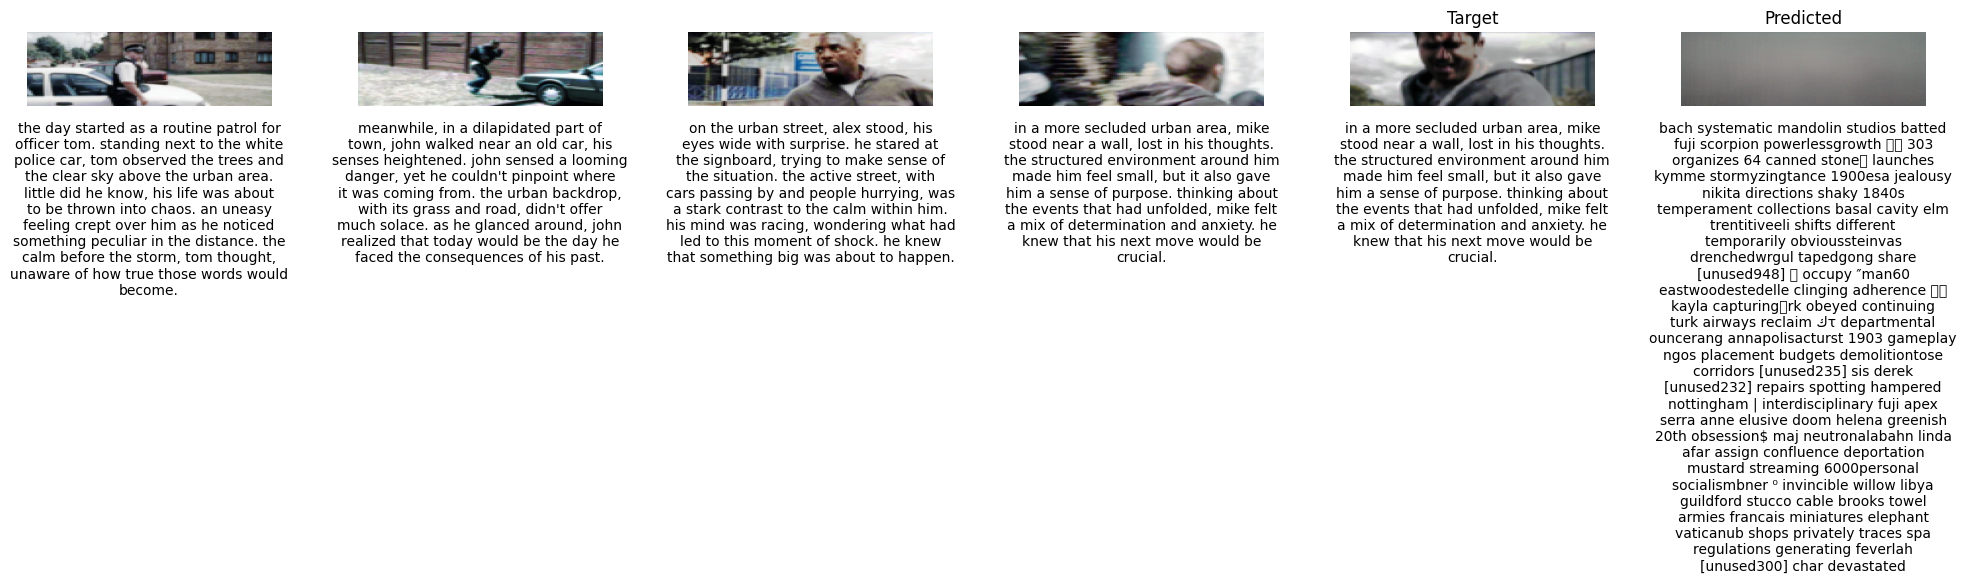

Validation on validation dataset
----------------


/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 23459 (\N{CJK UNIFIED IDEOGRAPH-5BA3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 33775 (\N{CJK UNIFIED IDEOGRAPH-83EF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 12422 (\N{HIRAGANA LETTER YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1942231843.py:90: UserWarning: Glyph 29356 (\N{CJK UNIFIED IDEOGRAPH-72AC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23459 (\N{CJK UNIFIED

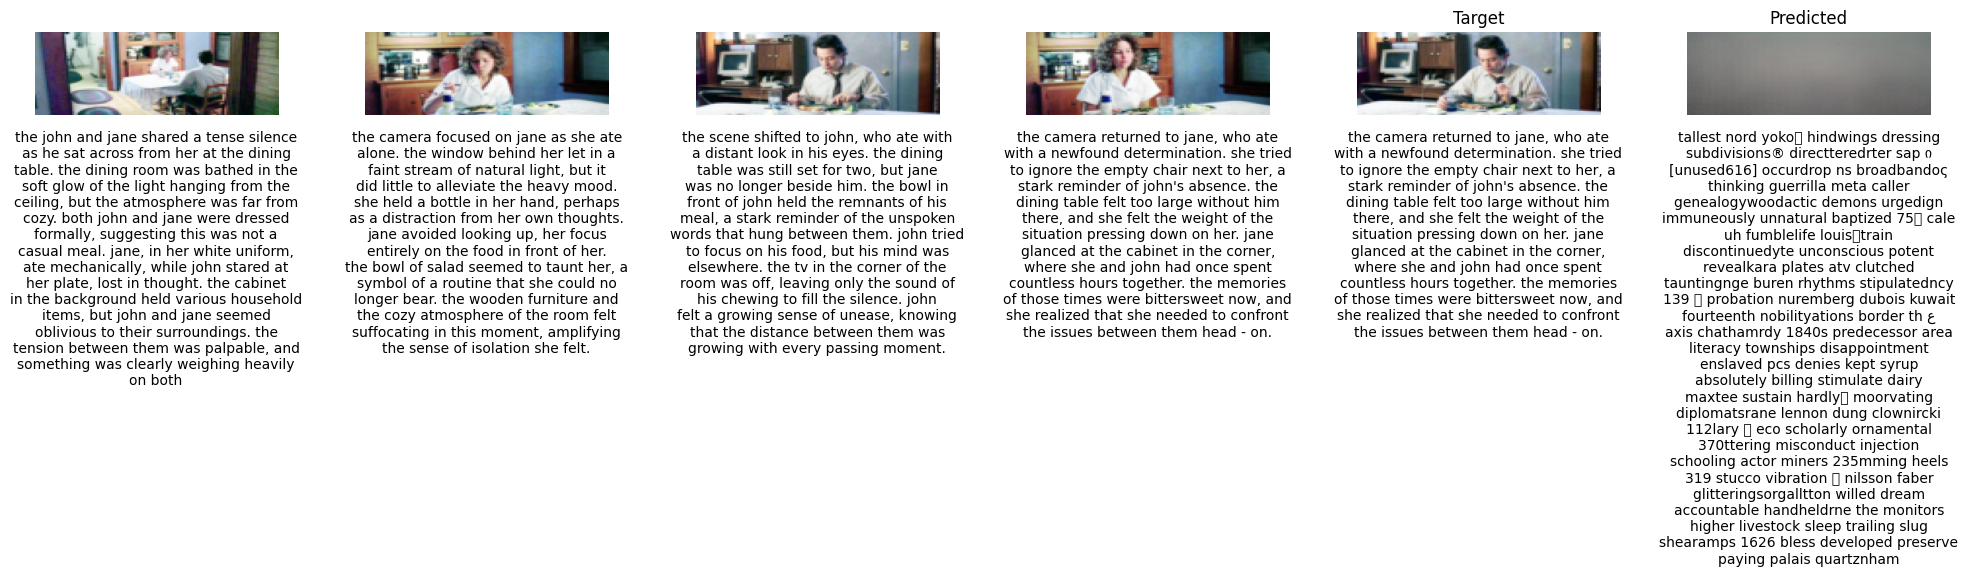

Epoch [5/5], Loss: 10.5455


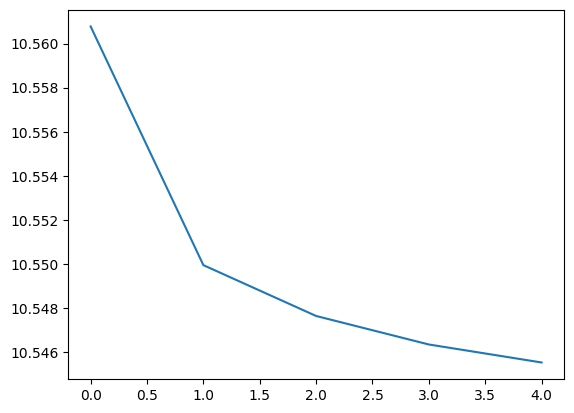

In [32]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Training loop for the sequence predictor
# Instantiate the model, define loss and optimizer

sequence_predictor.train()
losses = []

for epoch in range(N_EPOCHS):

    running_loss = 0.0
    for frames, descriptions, image_target, text_target  in train_dataloader:

      # Send images and tokens to the GPU
      descriptions = descriptions.to(device)
      frames = frames.to(device)
      image_target = image_target.to(device)
      text_target = text_target.to(device)
      # Predictions from our model
      pred_image_content, pred_image_context, predicted_text_logits_k, _, _ = sequence_predictor(frames, descriptions, text_target)
      # Computing losses
      # Loss for image reconstruction
      loss_im = criterion_images(pred_image_content, image_target)
      # Loss for the average pattern the images contain
      mu_global = frames.mean(dim=[0, 1])
      mu_global = mu_global.unsqueeze(0).expand_as(pred_image_context)
      loss_context = criterion_ctx(pred_image_context, mu_global)
      # Loss function for the text prediction
      prediction_flat = predicted_text_logits_k.reshape(-1, tokenizer.vocab_size)
      target_labels = text_target.squeeze(1)[:, 1:] # Slice to get [8, 119]
      target_flat = target_labels.reshape(-1)
      loss_text = criterion_text(prediction_flat, target_flat)
      # Combining the losses
      loss = loss_im + loss_text + 0.2*loss_context
      # Optimizing
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * frames.size(0)

    # checking model performance on validation set
    sequence_predictor.eval()
    print("Validation on training dataset")
    print( "----------------")
    validation( sequence_predictor, train_dataloader )
    print("Validation on validation dataset")
    print( "----------------")
    validation( sequence_predictor, val_dataloader)
    sequence_predictor.train()

    # scheduler.step()
    epoch_loss = running_loss / len(train_dataloader.dataset)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Loss: {epoch_loss:.4f}')

    if epoch % 5 == 0:
      save_checkpoint_to_drive(sequence_predictor, optimizer, epoch, epoch_loss, filename=f"sequence_predictor.pth")

# Do better plots
plt.plot(losses)
plt.show()


In [33]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Example text reconstruction task

# Unfreeze the model so gradients can flow
for p in text_autoencoder.parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(text_autoencoder.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token))
N_EPOCHS = 5

for epoch in range(N_EPOCHS):
    text_autoencoder.train()
    epoch_loss = 0
    for description in text_dataloader:
        # Move the "sentences" to device
        input_ids = tokenizer(description, return_tensors="pt",  padding=True, truncation=True).input_ids
        input_ids = input_ids.to(device)

        # zero the grad, then forward pass
        optimizer.zero_grad()
        outputs = text_autoencoder(input_ids, input_ids)
        # compute the loss: compare 3D logits to 2D targets
        loss = loss_fn(outputs.reshape(-1, tokenizer.vocab_size), input_ids[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{N_EPOCHS}; Avg loss {epoch_loss/len(text_dataloader)}; Latest loss {loss.item()}")
    torch.save(text_autoencoder.state_dict(), f"seq2seq-epoch-{epoch+1}.pth")

# # saving checkpoint to drive
save_checkpoint_to_drive(text_autoencoder, optimizer, 3*N_EPOCHS, loss, filename = "text_autoencoder.pth")

Epoch 1/5; Avg loss 6.571419087616173; Latest loss 6.028632640838623
Epoch 2/5; Avg loss 5.84692231599275; Latest loss 5.471668243408203
Epoch 3/5; Avg loss 5.517519445032687; Latest loss 5.498457908630371
Epoch 4/5; Avg loss 5.237150623454704; Latest loss 5.241111755371094
Epoch 5/5; Avg loss 5.042281390310408; Latest loss 5.027502059936523
Saved checkpoint: /content/gdrive/MyDrive/dl_checkpoints/text_autoencoder.pth


/tmp/ipython-input-3997486302.py:18: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  "loss": float(loss),


In [34]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Image reonstruction task

# To-Do: Use previous labs if you want to pretrain your visual encoder

# **Appendix**

This code computes the average images in case you want to use them. Notice that the average should be all zeros!

Starting Pass 1: Calculating Mean...
Starting Pass 2: Calculating Variance...
Computation Complete. std_images is a list of 5 tensors (3x60x125).
tensor(0.1514) tensor(0.2730)
tensor(0.1541) tensor(0.2722)
tensor(0.1463) tensor(0.2815)
tensor(0.1553) tensor(0.2693)
tensor(0.1451) tensor(0.2802)


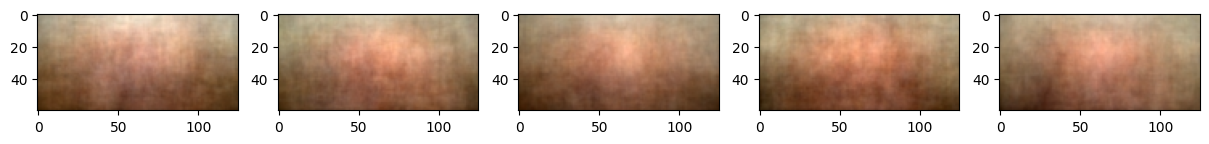

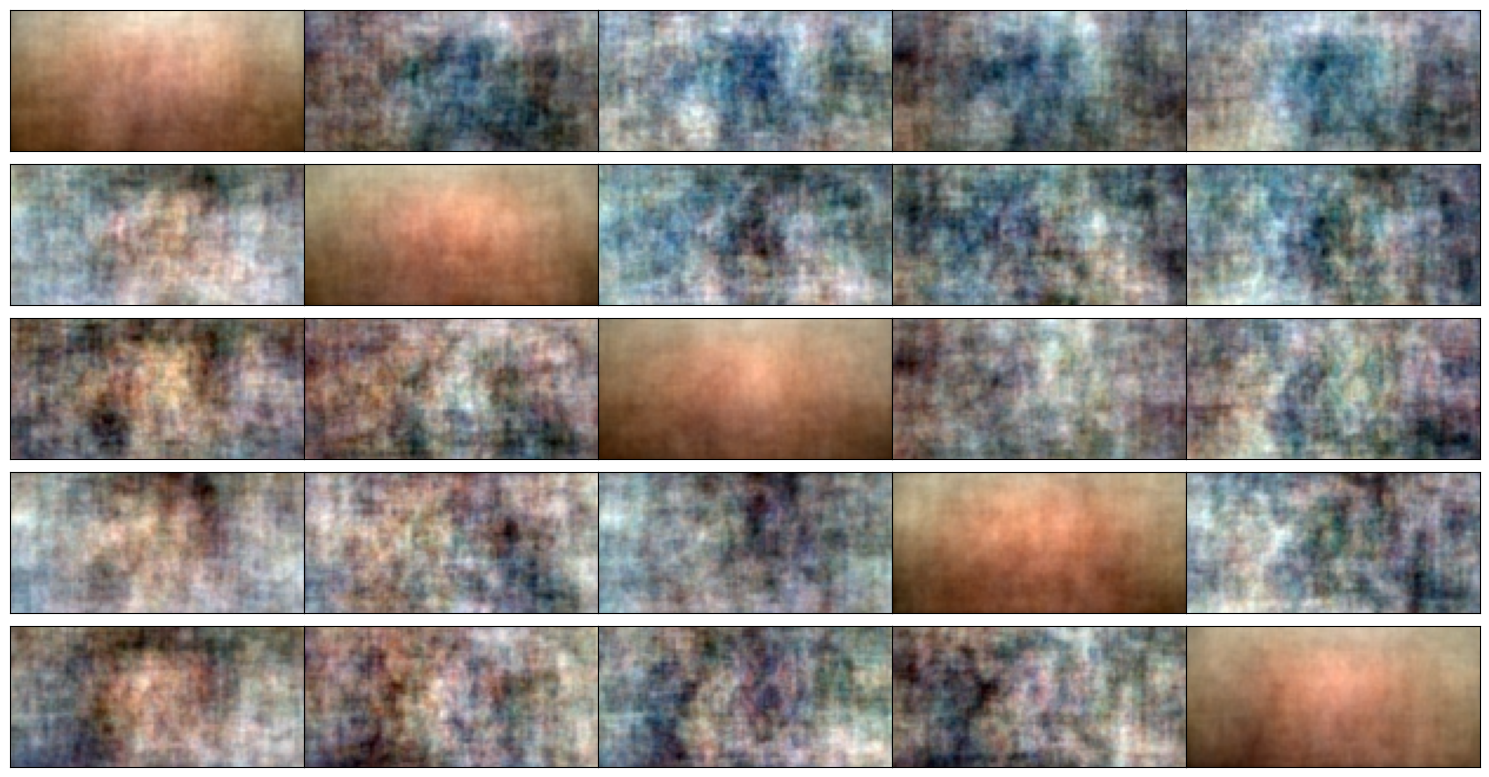

In [37]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Computing and showing average images
N = 1000
H, W = 60, 125

# Tensors to accumulate sum (for mean) and sum of squares (for variance)
avg_images = [torch.zeros((3, H, W)) for _ in range(5)]
sum_sq_diff = [torch.zeros((3, H, W)) for _ in range(5)] # Placeholder for variance numerator
transform = transforms.Compose([
    transforms.Resize((H, W)), # Add this line to resize images
    transforms.ToTensor()
])

# --- First Pass: Calculate the Sum (for Mean) ---
print("Starting Pass 1: Calculating Mean...")

for i in range(N):
    # Process sequence i
    sequence = train_dataset[i]["images"]

    for j in range(5):
        image = transform(sequence[j])
        avg_images[j] += image # Sum for mean

# Final step for mean
for j in range(5):
    avg_images[j] /= N

print("Starting Pass 2: Calculating Variance...")

for i in range(N):
    # Process sequence i
    sequence = train_dataset[i]["images"]

    for j in range(5):
        image = transform(sequence[j])

        # Calculate (Image - Mean)^2
        # Note: We detach the mean from the computation graph if it were being trained,
        # but here we're just using it as a fixed statistical value.
        diff = image - avg_images[j]
        sum_sq_diff[j] += diff * diff # Element-wise squaring

# --- Final step for Standard Deviation ---
std_images = []
for j in range(5):
    # Variance = Sum of Squared Differences / N
    variance = sum_sq_diff[j] / N

    # Standard Deviation = sqrt(Variance)
    std_dev = torch.sqrt(variance)
    std_images.append(std_dev)

print("Computation Complete. std_images is a list of 5 tensors (3x60x125).")
# You now have the 5 tensors you need for normalization (mean and std).

fig, ax = plt.subplots(1,5, figsize=(15,5))
for i in range(5):
  avg_image = avg_images[i]

  # Printing range of avg_image
  print(torch.min(avg_image), torch.max(avg_image))

  avg_imagen = (avg_image - torch.min(avg_image))/(torch.max(avg_image) - torch.min(avg_image))
  show_image(ax[i], avg_imagen)

# Create a matrix of images with the differences between avg_images
fig, ax = plt.subplots(5,5, figsize=(15,8))

for i in range(5):
  for j in range(5):
    if i == j:
      avg_image = avg_images[i]
      avg_imagen = (avg_image - torch.min(avg_image))/(torch.max(avg_image) - torch.min(avg_image))
      show_image(ax[i,j], avg_imagen)
    else:
      diff = avg_images[i] - avg_images[j]
      diff = (diff - torch.min(diff))/(torch.max(diff) - torch.min(diff))
      show_image(ax[i,j], diff)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
plt.tight_layout()
plt.subplots_adjust(
    wspace=0, # Set horizontal space to zero
    hspace=0  # Set vertical space to zero
)


## Chapter 3: Storytelling score prediction (Temporal + Tags)
This section implements a temporal frame model + tag embeddings for predicting a `story_score` label.


In [38]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Tag vocabulary + encoding utilities
from collections import Counter

def build_tag_vocab(samples, min_freq=1):
    """
    Build tag vocabulary from TRAIN samples only.
    Expected sample format (dict-like):
      sample["story"] (GDI text) OR sample has explicit lists: sample["objects"], sample["actions"], sample["locations"]
    Returns: tag2id dict, id2tag dict
    """
    c = Counter()
    for s in samples:
        tags = []
        # If your dataset already provides tags as lists:
        for k in ("objects", "actions", "locations"):
            if k in s and isinstance(s[k], (list, tuple)):
                tags.extend([str(x) for x in s[k]])

        # Otherwise parse from story text (GDI)
        if not tags and ("story" in s):
            attrs = parse_gdi_text(s["story"])
            for fr in attrs:
                for k in ("objects", "actions", "locations"):
                    tags.extend([str(x) for x in fr.get(k, [])])

        c.update(tags)

    tag2id = {"<PAD>": 0, "<UNK>": 1}
    for tag, freq in c.items():
        if freq >= min_freq and tag not in tag2id:
            tag2id[tag] = len(tag2id)
    id2tag = {v: k for k, v in tag2id.items()}
    return tag2id, id2tag


def encode_tags(tag_list, tag2id, max_tags=32):
    """
    tag_list: list[str]
    Returns:
      tag_ids: [max_tags] long
      tag_mask: [max_tags] float (1 real, 0 pad)
    """
    ids = [tag2id.get(str(t), tag2id["<UNK>"]) for t in (tag_list or [])][:max_tags]
    mask = [1.0] * len(ids)
    while len(ids) < max_tags:
        ids.append(tag2id["<PAD>"])
        mask.append(0.0)
    return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.float32)


In [39]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Dataset for storytelling score prediction (frames + tags + story_score)
from PIL import Image

class StoryScoreDataset(Dataset):
    """
    Expects each sample to provide:
      - sample["images"] : list of image paths OR PIL images OR bytes that can be opened
      - sample["story_score"] : float/int label (human score)
      - tags: either explicit lists (objects/actions/locations) OR embedded in sample["story"] (GDI) parsable by parse_gdi_text
    """

    def __init__(self, dataset, tag2id, num_frames=8, max_tags=32, transform=None):
        self.dataset = dataset
        self.tag2id = tag2id
        self.num_frames = num_frames
        self.max_tags = max_tags
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.dataset)

    def _uniform_sample(self, frames):
        if len(frames) <= self.num_frames:
            idxs = list(range(len(frames)))
        else:
            idxs = torch.linspace(0, len(frames)-1, steps=self.num_frames).long().tolist()
        chosen = [frames[i] for i in idxs]
        # If fewer frames than num_frames, pad by repeating last
        while len(chosen) < self.num_frames:
            chosen.append(chosen[-1])
        return chosen

    def _load_image(self, item):
        # item can be a path, PIL Image, or dict-like depending on dataset.
        if isinstance(item, Image.Image):
            img = item.convert("RGB")
        elif isinstance(item, str):
            img = Image.open(item).convert("RGB")
        elif isinstance(item, dict) and "path" in item:
            img = Image.open(item["path"]).convert("RGB")
        else:
            # Fallback: try PIL open on bytes-like
            try:
                img = Image.open(item).convert("RGB")
            except Exception as e:
                raise ValueError(f"Unsupported image item type: {type(item)}") from e
        return img

    def _get_tags(self, sample):
        # Prefer explicit lists if present
        tags = []
        for k in ("objects", "actions", "locations"):
            if k in sample and isinstance(sample[k], (list, tuple)):
                tags.extend([str(x) for x in sample[k]])
        if tags:
            return tags

        # Otherwise parse tags per-frame from GDI story and pool
        if "story" in sample:
            attrs = parse_gdi_text(sample["story"])
            for fr in attrs:
                for k in ("objects", "actions", "locations"):
                    tags.extend([str(x) for x in fr.get(k, [])])
        return tags

    def __getitem__(self, idx):
        s = self.dataset[idx]

        if "story_score" not in s:
            raise KeyError("Dataset sample is missing 'story_score'. "
                           "Please add a numeric storytelling score field (e.g., story_score) to each sample.")

        frames_raw = s.get("images", None)
        if frames_raw is None:
            raise KeyError("Dataset sample is missing 'images' (frames). Provide a list of frames in sample['images'].")

        frames_raw = list(frames_raw)
        frames_raw = self._uniform_sample(frames_raw)

        frame_tensors = []
        for fr in frames_raw:
            img = self._load_image(fr)
            img = FT.equalize(img)
            frame_tensors.append(self.transform(img))
        frames = torch.stack(frame_tensors, dim=0)  # [T,C,H,W]

        tags = self._get_tags(s)
        tag_ids, tag_mask = encode_tags(tags, self.tag2id, max_tags=self.max_tags)

        score = torch.tensor(float(s["story_score"]), dtype=torch.float32)

        return frames, tag_ids, tag_mask, score


In [46]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Model: CNN frame encoder + LSTM temporal module + tag embeddings + regression head
import torchvision.models as models

class FrameEncoder(nn.Module):
    # Modified to accept an instantiated backbone module and its input feature dimension
    def __init__(self, backbone_module: nn.Module, in_features_dim: int, output_projection_dim=512):
        super().__init__()
        self.model = backbone_module
        # The .fc layer is already set to nn.Identity() in the calling code
        self.proj = nn.Linear(in_features_dim, output_projection_dim) if in_features_dim != output_projection_dim else nn.Identity()
        self.out_dim = output_projection_dim # Store the output dimension for consistency

    def forward(self, x):
        # x: [B*T, C, H, W]
        f = self.model(x)         # [B*T, in_features_dim]
        f = self.proj(f)          # [B*T, output_projection_dim]
        return f


class VideoTagStoryScorer(nn.Module):
    # Modified to accept visual_backbone and its in_features_dim
    def __init__(self, visual_backbone: nn.Module, visual_backbone_in_features_dim: int, num_tags: int, frame_encoder_output_dim=512, tag_dim=64, lstm_hidden=256, dropout=0.2):
        super().__init__()
        # Initialize frame_encoder with the provided backbone module and its dimensions
        self.frame_encoder = FrameEncoder(
            backbone_module=visual_backbone,
            in_features_dim=visual_backbone_in_features_dim,
            output_projection_dim=frame_encoder_output_dim
        )
        self.lstm = nn.LSTM(input_size=self.frame_encoder.out_dim, hidden_size=lstm_hidden, batch_first=True)

        self.tag_emb = nn.Embedding(num_tags, tag_dim, padding_idx=0)
        self.tag_proj = nn.Linear(tag_dim, tag_dim)

        fusion_dim = lstm_hidden + tag_dim
        self.regressor = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1),
        )

    def forward(self, frames, tag_ids, tag_mask):
        # frames: [B,T,C,H,W]
        B, T, C, H, W = frames.shape
        x = frames.view(B*T, C, H, W)
        feats = self.frame_encoder(x).view(B, T, -1)  # [B,T,frame_encoder_output_dim]

        _, (h, _) = self.lstm(feats)
        video_repr = h[-1]  # [B,lstm_hidden]

        te = self.tag_emb(tag_ids)                 # [B,MaxTags,tag_dim]
        m = tag_mask.unsqueeze(-1)                 # [B,MaxTags,1]
        te = te * m
        denom = m.sum(dim=1).clamp(min=1.0)
        tag_repr = te.sum(dim=1) / denom          # [B,tag_dim]
        tag_repr = self.tag_proj(tag_repr)

        fused = torch.cat([video_repr, tag_repr], dim=-1)
        score = self.regressor(fused).squeeze(-1)  # [B]
        return score


In [41]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Training / evaluation utilities (MSE, MAE, Pearson)
def pearson_corr(x, y, eps=1e-8):
    x = x - x.mean()
    y = y - y.mean()
    denom = (x.std(unbiased=False) * y.std(unbiased=False)).clamp(min=eps)
    return (x * y).mean() / denom

def run_epoch(model, loader, optimizer=None, device="cpu"):
    train = optimizer is not None
    model.train() if train else model.eval()

    mse_fn = nn.MSELoss()
    total_mse = 0.0
    total_mae = 0.0
    preds_all = []
    ys_all = []
    n = 0

    for frames, tag_ids, tag_mask, y in loader:
        frames = frames.to(device)
        tag_ids = tag_ids.to(device)
        tag_mask = tag_mask.to(device)
        y = y.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            pred = model(frames, tag_ids, tag_mask)
            loss = mse_fn(pred, y)

            if train:
                loss.backward()
                optimizer.step()

        total_mse += loss.item() * y.size(0)
        total_mae += (pred - y).abs().sum().item()
        preds_all.append(pred.detach().cpu())
        ys_all.append(y.detach().cpu())
        n += y.size(0)

    preds_all = torch.cat(preds_all)
    ys_all = torch.cat(ys_all)
    corr = pearson_corr(preds_all, ys_all).item()

    return {
        "mse": total_mse / n,
        "mae": total_mae / n,
        "pearson": corr,
    }


In [42]:
# ==============================
# This cell is part of the modified model
# All comments are written in simple English
# ==============================

# @title Example wiring (requires dataset with 'story_score') - adjust splits to VIDEO LEVEL
# NOTE:
# - Build tag vocab ONLY from train split to avoid leakage.
# - Ensure splitting is at the video/story level (not frame level).

# Example (placeholder) split:
# train_data = train_dataset
# val_data = test_dataset  # replace with your real val split

# tag2id, id2tag = build_tag_vocab(train_data, min_freq=1)
# train_ds = StoryScoreDataset(train_data, tag2id, num_frames=8, max_tags=32)
# val_ds   = StoryScoreDataset(val_data,   tag2id, num_frames=8, max_tags=32)

# train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
# val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=2)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = VideoTagStoryScorer(num_tags=len(tag2id)).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# for epoch in range(5):
#     tr = run_epoch(model, train_loader, optimizer=optimizer, device=device)
#     va = run_epoch(model, val_loader, optimizer=None, device=device)
#     print(f"epoch {epoch} | train {tr} | val {va}")


In [50]:
# ==============================
# End-to-end training pipeline + checkpoint saving
# ==============================

import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18

def set_seed(seed=42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Image preprocessing for ResNet-style encoders
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load samples from CSV if it exists; otherwise fall back to a small synthetic dataset
samples = load_samples_from_csv(METADATA_CSV, FRAME_SOURCE)

if len(samples) == 0:
    # Synthetic fallback: creates random images and random tags so the pipeline can run end-to-end.
    # Replace this with your real metadata.csv for actual training.
    print("metadata.csv not found or empty. Using a small synthetic dataset for a sanity-check run.")
    synthetic_dir = Path("synthetic_frames")
    synthetic_dir.mkdir(exist_ok=True)

    from PIL import Image
    for vid in range(6):
        vdir = synthetic_dir / f"vid_{vid:03d}"
        vdir.mkdir(exist_ok=True)
        frame_paths_for_video = [] # Collect paths for the 'images' key
        for t in range(10):
            arr = (np.random.rand(224, 224, 3) * 255).astype(np.uint8)
            frame_path = vdir / f"{t:04d}.jpg"
            Image.fromarray(arr).save(frame_path)
            frame_paths_for_video.append(str(frame_path)) # Add path as string

    tag_pool = ["person", "car", "dog", "running", "cooking", "park", "street", "kitchen"]
    for vid in range(6):
        tags = random.sample(tag_pool, k=4)
        samples.append({
            "video_id": f"vid_{vid:03d}",
            "frames_dir": str(synthetic_dir / f"vid_{vid:03d}"),
            "images": frame_paths_for_video, # Explicitly add the list of image paths
            "tags": tags,
            "story_score": float(random.randint(1, 5)),
        })
    FRAME_SOURCE = "frames_dir"

# Build tag vocab from training samples only (we will split first)
def split_by_video(samples, train_frac=0.7, val_frac=0.15, seed=42):
    """Split samples by unique video_id to avoid leakage."""
    rng = random.Random(seed)
    vids = list({s.get("video_id", "") for s in samples})
    rng.shuffle(vids)
    n = len(vids)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    train_vids = set(vids[:n_train])
    val_vids = set(vids[n_train:n_train + n_val])
    test_vids = set(vids[n_train + n_val:])

    train = [s for s in samples if s.get("video_id", "") in train_vids]
    val = [s for s in samples if s.get("video_id", "") in val_vids]
    test = [s for s in samples if s.get("video_id", "") in test_vids]
    return train, val, test

train_samples, val_samples, test_samples = split_by_video(samples)

tag2id, id2tag = build_tag_vocab([s["tags"] for s in train_samples if "tags" in s], min_freq=1) # Ensure 'tags' key exists
num_tags = len(tag2id)

train_ds = StoryScoreDataset(train_samples, tag2id, transform=image_transform, num_frames=NUM_FRAMES, max_tags=MAX_TAGS)
val_ds = StoryScoreDataset(val_samples, tag2id, transform=image_transform, num_frames=NUM_FRAMES, max_tags=MAX_TAGS)
test_ds = StoryScoreDataset(test_samples, tag2id, transform=image_transform, num_frames=NUM_FRAMES, max_tags=MAX_TAGS)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Visual backbone: ResNet18 without the classification head
backbone = resnet18(weights="DEFAULT")
visual_backbone_in_features = backbone.fc.in_features # Store the original in_features
backbone.fc = nn.Identity() # Replace the classification head

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = backbone.to(device)

# Instantiate the model with the correct arguments
model = VideoTagStoryScorer(
    visual_backbone=backbone,
    visual_backbone_in_features_dim=visual_backbone_in_features,
    num_tags=num_tags,
    frame_encoder_output_dim=512, # The default for FrameEncoder's output_projection_dim
    tag_dim=64,
    lstm_hidden=256,
    dropout=0.2,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train_one_epoch(model, loader, optimizer, device):
    """Trains the model for one epoch."""
    model.train()
    total_mse = 0.0
    total_mae = 0.0
    mse_fn = nn.MSELoss()
    n = 0

    for frames, tag_ids, tag_mask, y in loader:
        frames = frames.to(device)
        tag_ids = tag_ids.to(device)
        tag_mask = tag_mask.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        pred = model(frames, tag_ids, tag_mask)
        loss = mse_fn(pred, y)
        loss.backward()
        optimizer.step()

        total_mse += loss.item() * y.size(0)
        total_mae += (pred - y).abs().sum().item()
        n += y.size(0)

    avg_mse = total_mse / max(n, 1)
    avg_mae = total_mae / max(n, 1)
    return avg_mse, avg_mae

def eval_metrics(model, loader, device):
    """Compute MSE, MAE, and Pearson correlation."""
    model.eval()
    mse_loss = nn.MSELoss(reduction="sum")
    y_true = []
    y_pred = []
    total_mse = 0.0
    total_abs = 0.0
    n = 0

    with torch.no_grad():
        for frames, tag_ids, tag_mask, y in loader:
            frames = frames.to(device)
            tag_ids = tag_ids.to(device)
            tag_mask = tag_mask.to(device)
            y = y.to(device)

            pred = model(frames, tag_ids, tag_mask)

            total_mse += mse_loss(pred, y).item()
            total_abs += (pred - y).abs().sum().item()
            n += y.size(0)

            y_true.extend(y.detach().cpu().tolist())
            y_pred.extend(pred.detach().cpu().tolist())

    mse = total_mse / max(n, 1)
    mae = total_abs / max(n, 1)

    # Pearson correlation (safe for small n)
    yt = np.array(y_true, dtype=np.float64)
    yp = np.array(y_pred, dtype=np.float64)
    if len(yt) >= 2 and np.std(yt) > 1e-12 and np.std(yp) > 1e-12:
        corr = float(np.corrcoef(yt, yp)[0, 1])
    else:
        corr = float("nan")

    return mse, mae, corr

best_val_mae = float("inf")
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_mse, train_mae = train_one_epoch(model, train_loader, optimizer, device)
    val_mse, val_mae, val_corr = eval_metrics(model, val_loader, device)

    print(f"Epoch {epoch:02d} | Train MSE {train_mse:.4f} MAE {train_mae:.4f} | Val MSE {val_mse:.4f} MAE {val_mae:.4f} Corr {val_corr}")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_state = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_mae": val_mae,
            "tag2id": tag2id,
            "config": {
                "NUM_FRAMES": NUM_FRAMES,
                "MAX_TAGS": MAX_TAGS,
                "BATCH_SIZE": BATCH_SIZE,
                "LEARNING_RATE": LEARNING_RATE,
            },
        }

# Save the best checkpoint (or the last if no validation set)
if best_state is None:
    best_state = {
        "epoch": EPOCHS,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "val_mae": None,
        "tag2id": tag2id,
        "config": {
            "NUM_FRAMES": NUM_FRAMES,
            "MAX_TAGS": MAX_TAGS,
            "BATCH_SIZE": BATCH_SIZE,
            "LEARNING_RATE": LEARNING_RATE,
        },
    }

torch.save(best_state, NEW_CHECKPOINT_PATH)
print(f"Saved new checkpoint to: {NEW_CHECKPOINT_PATH.resolve()}")

# Final test metrics
test_mse, test_mae, test_corr = eval_metrics(model, test_loader, device)
print(f"Test | MSE {test_mse:.4f} MAE {test_mae:.4f} Corr {test_corr}")


metadata.csv not found or empty. Using a small synthetic dataset for a sanity-check run.
Epoch 01 | Train MSE 12.2904 MAE 3.1401 | Val MSE 0.0000 MAE 0.0000 Corr nan
Saved new checkpoint to: /content/video_tag_story_scorer.pth
Test | MSE 13.1760 MAE 3.0292 Corr nan


## Generating a larger synthetic `metadata.csv` file and dummy frames

This code will create a `metadata.csv` file with 50 videos. Each video will have a randomly assigned story score and tags. For each video, it will also create a directory with 10 dummy `.jpg` files to simulate frames. This larger dataset should help in getting more representative training and validation metrics.

In [51]:
import pandas as pd
import numpy as np
import random
import os
from pathlib import Path
from PIL import Image

# Define paths and parameters for the synthetic dataset
DATA_ROOT_SYNTHETIC = Path("synthetic_large_dataset")
METADATA_CSV_SYNTHETIC = DATA_ROOT_SYNTHETIC / "metadata.csv"
NUM_VIDEOS = 50  # Number of synthetic videos
FRAMES_PER_VIDEO = 10 # Number of dummy frames per video
IMG_HEIGHT, IMG_WIDTH = 224, 224

# Ensure the root directory for synthetic data exists
DATA_ROOT_SYNTHETIC.mkdir(exist_ok=True, parents=True)

# Tag pool for generating random tags
tag_pool = ["person", "car", "dog", "running", "cooking", "park", "street", "kitchen", "city", "nature", "happy", "sad", "action", "adventure", "indoors", "outdoors"]

# List to hold data for the metadata.csv
metadata_rows = []

print(f"Generating {NUM_VIDEOS} synthetic videos with {FRAMES_PER_VIDEO} frames each...")

for i in range(NUM_VIDEOS):
    video_id = f"synth_video_{i:03d}"
    frames_dir_path = DATA_ROOT_SYNTHETIC / video_id
    frames_dir_path.mkdir(exist_ok=True)

    # Generate dummy frame files
    frame_paths_for_video = []
    for t in range(FRAMES_PER_VIDEO):
        # Create a dummy image (random pixels)
        arr = (np.random.rand(IMG_HEIGHT, IMG_WIDTH, 3) * 255).astype(np.uint8)
        frame_path = frames_dir_path / f"{t:04d}.jpg"
        Image.fromarray(arr).save(frame_path)
        frame_paths_for_video.append(str(frame_path))

    # Generate random story score and tags
    story_score = float(random.randint(1, 5))
    num_tags_for_video = random.randint(2, 5)
    video_tags = random.sample(tag_pool, k=num_tags_for_video)
    tags_str = ",".join(video_tags)

    metadata_rows.append({
        "video_id": video_id,
        "story_score": story_score,
        "tags": tags_str,
        "frames_dir": str(frames_dir_path.resolve()),
        "frame_paths": ";".join(frame_paths_for_video) # Add frame_paths explicitly for StoryScoreDataset
    })

# Create the DataFrame and save to CSV
metadata_df = pd.DataFrame(metadata_rows)
metadata_df.to_csv(METADATA_CSV_SYNTHETIC, index=False)

print(f"Successfully generated {NUM_VIDEOS} videos.")
print(f"Metadata saved to: {METADATA_CSV_SYNTHETIC.resolve()}")
print("First 5 rows of the generated metadata:")
print(metadata_df.head())

# Update global DATA_ROOT and METADATA_CSV to use the new synthetic dataset
DATA_ROOT = DATA_ROOT_SYNTHETIC
METADATA_CSV = METADATA_CSV_SYNTHETIC


Generating 50 synthetic videos with 10 frames each...
Successfully generated 50 videos.
Metadata saved to: /content/synthetic_large_dataset/metadata.csv
First 5 rows of the generated metadata:
          video_id  story_score                            tags  \
0  synth_video_000          2.0  happy,cooking,dog,running,park   
1  synth_video_001          1.0                      action,car   
2  synth_video_002          3.0          city,action,person,sad   
3  synth_video_003          4.0                      action,car   
4  synth_video_004          5.0     sad,nature,running,outdoors   

                                         frames_dir  \
0  /content/synthetic_large_dataset/synth_video_000   
1  /content/synthetic_large_dataset/synth_video_001   
2  /content/synthetic_large_dataset/synth_video_002   
3  /content/synthetic_large_dataset/synth_video_003   
4  /content/synthetic_large_dataset/synth_video_004   

                                         frame_paths  
0  synthetic_large

Now that a larger `metadata.csv` file has been created and the `DATA_ROOT` and `METADATA_CSV` global variables have been updated, you can re-run the end-to-end training pipeline. This should now use the larger synthetic dataset and provide more meaningful validation and test metrics. Remember to set `FRAME_SOURCE` appropriately if you wish to use `frame_paths` or `video_path` instead of `frames_dir`.